In [51]:
import adi

In [71]:
import heapq
from collections import defaultdict
import numpy as np
from collections import Counter
import heapq
import adi
from scipy.signal import lfilter

# Function to build a Huffman tree and generate the Huffman codes
def build_huffman_tree(symbols):
    # Count frequency of each 95-bit chunk
    frequency = defaultdict(int)
    for chunk in symbols:
        frequency[chunk] += 1
    
    # Create a priority queue (min-heap) based on frequencies
    heap = [[weight, [symbol, ""]] for symbol, weight in frequency.items()]
    heapq.heapify(heap)

    while len(heap) > 1:
        # Pop the two smallest elements
        lo = heapq.heappop(heap)
        hi = heapq.heappop(heap)

        # Create a new node with a combined frequency
        for pair in lo[1:]:
            pair[1] = '0' + pair[1]  # Add '0' to the left child
        for pair in hi[1:]:
            pair[1] = '1' + pair[1]  # Add '1' to the right child

        # Push the combined node back to the heap
        heapq.heappush(heap, [lo[0] + hi[0]] + lo[1:] + hi[1:])

    # The final heap will contain one element: the root of the Huffman tree
    huff_tree = heap[0]
    
    # Extract Huffman codes from the tree
    huff_codes = {symbol: code for symbol, code in huff_tree[1:]}
    
    return huff_codes

# Function to perform Huffman encoding on the input data
def huffman_encode(data, huff_codes):
    return ''.join(huff_codes[chunk] for chunk in data)

# Function to convert video to bits (assuming you already have this)
def video_to_bits(video_path):
    with open(video_path, 'rb') as video_file:
        video_data = video_file.read()

    bits = ''.join(format(byte, '08b') for byte in video_data)
    return bits

# Function to split video bits into 95-bit chunks
def split_into_chunks(bits, chunk_size=47491):
    return [bits[i:i+chunk_size] for i in range(0, len(bits), chunk_size)]

# Specify the path to your video file
video_path = 'DCCTVideo.mp4'

# Convert video to bits
video_bits = video_to_bits(video_path)
print(len(video_bits))
# Split video bits into 95-bit chunks (treating each chunk as a symbol)
chunks = split_into_chunks(video_bits, 47491)

# Build the Huffman tree and generate Huffman codes for the chunks
huffman_codes = build_huffman_tree(chunks)

# Encode the video chunks using the Huffman codes
huffman_encoded = huffman_encode(chunks, huffman_codes)

print((huffman_encoded))


23175608
0001100000111001101010010100110010100011100010111100100011111011010110110001111111111110100001100011010110011101000001110010100001001110110000111100010111110001101110100110011100101011000100000000010001011110000011011111110011110110001000110001000101101110001111001110001001010010010100111010011011000001111010101111001101010010111001011101000010011011111110111010100111011101001101000111000100001101110101000011110000100111111001111001111001101101010011111101011011001010000010000001010101110101000000100111110111111010011001100111110000100110101000100011101010100000111001101001111110110100110101100111011011010101100001010111001001110100101011110101111010111010000000111001000110001100110111001010011101000110101111110110010100010101111011110010100110111011001110000001011111100100011100101111101001001111000000010011000110000110010001110100101011000101001011010100101111001100010101010111011000010101001100110110101011000011000111000010110011111000011111101000111001001010010101111101111

In [72]:
repetition_factor = 10
channel = []
for elem in huffman_encoded:
    channel.extend([elem] * repetition_factor)


channel_encoded = ''.join(channel)  # Join with a comma and a space
print(len(channel_encoded))

43680


In [73]:

def bpsk_modulate(encoded_bits):
    return [1 if bit == '1' else -1 for bit in encoded_bits]

bpsk_signal = bpsk_modulate(channel_encoded)


# Barker Code
barker_code = np.array([1, 1, 1, 1, 1, -1, -1, 1, 1, -1, 1, -1, 1])

barker_code_string = ""



# Integrate Barker Code
bpsk_with_barker = np.concatenate((barker_code,bpsk_signal))

#These sequences are typically long, and the receiver can identify the start of the frame by correlating the received signal with the known sequence.


# Symbol Repetition (repeat 10 times)
repeated_signal = np.tile(bpsk_with_barker, 10)
print(len(repeated_signal))

# Upsampling by adding zeros (each symbol represented by 8 samples)
sps = 8
upsampled_signal = np.zeros(len(repeated_signal) * sps)
upsampled_signal[::sps] = repeated_signal


print(len(upsampled_signal))



436930
3495440


In [74]:

# Create raised-cosine filter
num_taps = 101
beta = 0.35
Ts = sps
t = np.arange(num_taps) - (num_taps - 1) // 2
p = np.sinc(t / Ts) * np.cos(np.pi * beta * t / Ts) / (1 - (2 * beta * t / Ts) ** 2)
p /= np.max(p)  # Normalize filter to avoid scaling issues

pulse_shaped_signal = np.convolve(upsampled_signal, p, mode='full')
print(len(pulse_shaped_signal))

# From PySDR
sample_rate = 2e6 # Hz
carrier_freq = 900e6 # Hz
num_samps = len(pulse_shaped_signal) # number of samples per call to rx()

sdr = adi.Pluto("ip:192.168.2.1")
sdr.sample_rate = int(sample_rate)

# Config Tx
sdr.tx_rf_bandwidth = int(sample_rate) # filter cutoff, just set it to the same as sample rate
sdr.tx_lo = int(carrier_freq)
sdr.tx_hardwaregain_chan0 = 0 # Increase to increase tx power, valid range is -90 to 0 dB

# Config Rx

#sdr1 = adi.Pluto("ip:192.168.2.1")
sdr.rx_lo = int(carrier_freq)
sdr.rx_rf_bandwidth = int(sample_rate)
sdr.rx_buffer_size = num_samps
sdr.gain_control_mode_chan0 = 'manual'
sdr.rx_hardwaregain_chan0 = -10 # dB, increase to increase the receive gain, but be careful not to saturate the ADC

# Normalize to PlutoSDR range
transmitted1 = pulse_shaped_signal * 2**12

# Start the transmitter
sdr.tx_cyclic_buffer = True  # Enable cyclic buffers
sdr.tx(transmitted1)  # Start transmitting

# Clear buffer just to be safe
for i in range(0, 10):
    raw_data = sdr.rx()

# Receive samples
rx_samples = sdr.rx()
print(rx_samples)

# Stop transmitting
sdr.tx_destroy_buffer()


3495540
[28.+7.j 27.+6.j 27.+6.j ... 25.+7.j 26.+7.j 26.+7.j]


In [75]:
signal_data = np.real(rx_samples)

# Define a function to create a raised cosine filter
def raised_cosine_filter(num_taps, rolloff, sps):
    t = np.arange(-num_taps // 2, num_taps // 2 + 1) / sps  # Time vector
    h = np.zeros_like(t)

    # Raised cosine filter formula
    for i in range(len(t)):
        if t[i] == 0:
            h[i] = 1 - rolloff + (4 * rolloff / np.pi)  # Center tap
        elif abs(t[i]) == 1 / (2 * rolloff):
            h[i] = (rolloff / np.sqrt(2)) * (
                1 + np.cos(np.pi * (1 / rolloff)))  # Edge tap
        else:
            h[i] = (np.sin(np.pi * t[i]) / (np.pi * t[i])) * \
                    np.cos(np.pi * rolloff * t[i]) / (1 - (4 * rolloff * t[i]) ** 2)

    # Normalize the filter
    h /= np.sum(h)

    return h

# Design the raised cosine filter
num_taps = 101
rolloff = 0.35
sps = 8  # Samples per symbol
rcos_filter = raised_cosine_filter(num_taps, rolloff, sps)
matched_filter = rcos_filter[::-1]  # Reverse for matched filtering

In [76]:
# Apply the matched filter
filtered_signal = np.convolve(signal_data, matched_filter, mode='same')
#filtered_signal = lfilter(rcos_filter,1.0,signal_data)
# Downsample the signal
downsampled_signal = filtered_signal[::sps]

15604
[15604, 59297, 102990, 146683, 190376, 234069, 277762, 321455, 365148, 408854]
[ 1.  1.  1.  1.  1. -1. -1.  1.  1. -1.  1. -1.  1.]


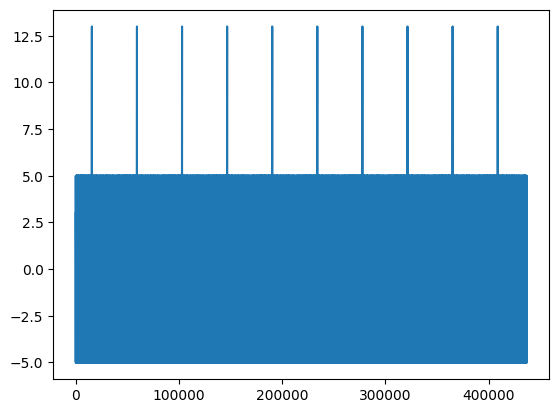

In [77]:
import matplotlib.pyplot as plt
# Symbol detection
detected_symbols = np.sign(downsampled_signal)

# Replace zeros with -1
detected_symbols[detected_symbols == 0] = -1


# Barker code sequence
barker_code = np.array([1, 1, 1, 1, 1, -1, -1, 1, 1, -1, 1, -1, 1])
barker_code_flip = np.array([-1, -1, -1, -1, -1, 1, 1, -1, -1, 1, -1, 1, -1])
# Cross-correlation with Barker code
correlation = np.correlate(detected_symbols, barker_code, mode='valid')

def find_subsequence(main_array, subsequence1,subsequence2):
    
    for i in range(len(main_array) - len(subsequence1) + 1):
          if np.array_equal(main_array[i:i+len(subsequence1)], subsequence1):           
              return i
          elif  np.array_equal(main_array[i:i+len(subsequence2)], subsequence2):           
              return i
    return -1  
start_idx = find_subsequence(detected_symbols,barker_code,barker_code_flip)

print(start_idx)

indices = []
for i in range(len(correlation)):
    if abs(correlation[i])==13:
        indices.append(i)
print(indices)

#start_idx = np.argmax(correlation)

plt.plot(correlation)
print(detected_symbols[start_idx:start_idx+13])
# Extract the BPSK signal without the Barker codebpsk_length = len(bpsk_with_barker)
# Length of BPSK with Barker code
bpsk_length = len(bpsk_with_barker)
extracted_bpsk_signal = detected_symbols[start_idx + len(barker_code):start_idx + bpsk_length]


In [78]:
# Decode the BPSK signal back to bits
decoded_bits = ['1' if symbol > 0 else '0' for symbol in extracted_bpsk_signal]

# Reconstruct the Huffman encoded bitstream
channel_encoded_received = ''.join(decoded_bits)


def repetition_decode(received, n):
    decoded = []
    for i in range(0, len(received), n):
        # Take a majority vote over the n bits
        group = received[i:i+n]
        majority_bit = '1' if group.count('1') > group.count('0') else '0'
        decoded.append(majority_bit)
    return decoded

channel_decoded = repetition_decode(channel_encoded_received,repetition_factor)
channel_decode = ''.join(channel_decoded)

pe = 0
for i in range(len(channel_decode)):
    if channel_decode[i]!=huffman_encoded[i]:
    
        pe = pe+1
print(pe)
if pe == 4368:
   
        channel_decode = ['0' if bit == '1' else '1' for bit in channel_decode]

channel_decode = ''.join(channel_decode)

print((channel_decode))


0
00011000001110011010100101001100101000111000101111001000111110110101101100011111111111101000011000110101100111010000011100101000010011101100001111000101111100011011101001100111001010110001000000000100010111100000110111111100111101100010001100010001011011100011110011100010010100100101001110100110110000011110101011110011010100101110010111010000100110111111101110101001110111010011010001110001000011011101010000111100001001111110011110011110011011010100111111010110110010100000100000010101011101010000001001111101111110100110011001111100001001101010001000111010101000001110011010011111101101001101011001110110110101011000010101110010011101001010111101011110101110100000001110010001100011001101110010100111010001101011111101100101000101011110111100101001101110110011100000010111111001000111001011111010010011110000000100110001100001100100011101001010110001010010110101001011110011000101010101110110000101010011001101101010110000110001110000101100111110000111111010001110010010100101011111011111100110

In [79]:
# Decoding function with length check
def huffman_decode(encoded_bitstream, reverse_huffman_codes):
    huffman_decoded = ''
    current_code = ''
    decoded_characters = 0  # Count of decoded characters

    for bit in encoded_bitstream:
        current_code += bit

        # If the current code matches any of the Huffman codes
        if current_code in reverse_huffman_codes:
            huffman_decoded += reverse_huffman_codes[current_code]
            decoded_characters += 1
            current_code = ''  # Reset on successful match

            

    return huffman_decoded



# Call the decode function
reverse_huffman_codes = {code: char for char, code in huffman_codes.items()}

# Decode the Huffman encoded message
huffman_decoded = huffman_decode(channel_decode, reverse_huffman_codes)
print(len(huffman_decoded))


23175608


In [80]:
def bits_to_video(bits, output_path):
    # Ensure the length of the bits is a multiple of 8 (each byte is 8 bits)
    if len(bits) % 8!= 0:
        raise ValueError("The bits string length must be a multiple of 8.")
    
    # Convert the bits back to bytes
    video_data = bytearray()
    for i in range(0, len(bits), 8):
        byte = bits[i:i+8]  # Take 8 bits at a time
        video_data.append(int(byte, 2))  # Convert the 8-bit string to an integer and append to the bytearray
    
    # Write the bytes back to a video file
    with open(output_path, 'wb') as video_file:
        video_file.write(video_data)

# Example usage
output_path = 'DCCT_output_SDR.mp4'  # Path to save the reconstructed video

# Convert the bits back to video
bits_to_video(huffman_decoded, output_path)